# Manual Training VQGAN ImageNet F16 Tokenizer (VQ-VAE)
This notebook shows how to fine-tune the CompVis VQGAN ImageNet F16 tokenizer on your custom flat folder of frames, with manual training loop.

Steps:
1. Install dependencies
2. Configure paths & hyperparameters
3. Download pretrained VQGAN checkpoint
4. Load and split the dataset
5. Define the model and load pretrained weights
6. (Optional) Freeze parts of the model
7. Setup optimizer and Weights & Biases
8. Custom training loop
9. Evaluation and save codebook


In [11]:
# 1. Install dependencies
!pip install torch torchvision taming-transformers datasets accelerate wandb huggingface_hub
# Clone taming-transformers in case PyPI lacks modules
!git clone https://github.com/CompVis/taming-transformers.git
!pip install -e taming-transformers
!pip install torch torchvision taming-transformers datasets accelerate wandb huggingface_hub
!pip install "pytorch-lightning<2.0"
!pip install taming-transformers-rom1504


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# prompt: unzip /content/drive/MyDrive/cosmos_training/cosmos_training frames.zip in a folder inside content

import os

# Define the destination folder
destination_folder = '/content/unzipped_frames'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Unzip the file
!unzip /content/drive/MyDrive/cosmos_training/cosmos_training\ frames.zip -d {destination_folder}

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf06_idx11.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf07_idx13.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf08_idx15.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf09_idx17.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf10_idx19.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf11_idx21.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf12_idx23.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf13_idx25.jpg  
  inflating: /content/unzipped_frames/cosmos_training frames/fE6xxSbjVV8_6-8-rgb_front_kf1

In [50]:

from dataclasses import dataclass
import torch
import os

@dataclass
class Config:
    data_dir: str        = "/content/unzipped_frames/cosmos_training frames"
    batch_size: int      = 12
    image_size: int      = 256
    num_codes: int       = 16384
    code_dim: int        = 256
    latent_dim: int      = 3
    learning_rate: float = 2e-4
    num_epochs: int      = 3
    save_dir: str        = "./checkpoints"
    device: str          = "cuda" if torch.cuda.is_available() else "cpu"
    project_name: str    = "vqgan-imagenet-f16"
    pretrained_ckpt: str = "checkpoints/vqgan_imagenet_f16_1024.ckpt"
    config_yaml: str     = "checkpoints/vqgan_imagenet_f16_1024.yaml"

cfg = Config()
print(cfg)


Config(data_dir='/content/unzipped_frames/cosmos_training frames', batch_size=12, image_size=256, num_codes=16384, code_dim=256, latent_dim=3, learning_rate=0.0002, num_epochs=3, save_dir='./checkpoints', device='cuda', project_name='vqgan-imagenet-f16', pretrained_ckpt='checkpoints/vqgan_imagenet_f16_1024.ckpt', config_yaml='checkpoints/vqgan_imagenet_f16_1024.yaml')


In [1]:
!mkdir checkpoints
# Download the public 16 384-code VQGAN F16 checkpoint
!curl -L -o checkpoints/vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
!curl -L -o checkpoints/vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0   1137      0 --:--:-- --:--:-- --:--:--  1137
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
^C


In [6]:
!mkdir checkpoints
!curl -L -o checkpoints/vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1'
!curl -L -o checkpoints/vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'

mkdir: cannot create directory ‘checkpoints’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   645  100   645    0     0    799      0 --:--:-- --:--:-- --:--:--     0
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  913M  100  913M    0     0  14.8M      0  0:01:01  0:01:01 --:--:-- 14.9M


In [51]:

import yaml

with open(cfg.config_yaml, 'r') as f:
    full_cfg = yaml.safe_load(f)

# Usually the model section lives under a key like "model"
model_cfg = full_cfg['model']

ddconfig    = model_cfg['params']['ddconfig']
lossconfig  = model_cfg['params']['lossconfig']
n_embed     = model_cfg['params']['n_embed']
embed_dim   = model_cfg['params']['embed_dim']

print("Loaded ddconfig keys:", ddconfig.keys())
print("n_embed:", n_embed, "embed_dim:", embed_dim)


Loaded ddconfig keys: dict_keys(['double_z', 'z_channels', 'resolution', 'in_channels', 'out_ch', 'ch', 'ch_mult', 'num_res_blocks', 'attn_resolutions', 'dropout'])
n_embed: 1024 embed_dim: 256


In [52]:
# 4. Load and split dataset
import os, glob
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

files = glob.glob(os.path.join(cfg.data_dir, "*.jpg"))
train_f, temp = train_test_split(files, test_size=0.2, random_state=42)
val_f, test_f = train_test_split(temp, test_size=0.5, random_state=42)
print(f"Train/Val/Test = {len(train_f)}/{len(val_f)}/{len(test_f)} images")

tfms = transforms.Compose([
    transforms.Resize(cfg.image_size),
    transforms.CenterCrop(cfg.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class ImgDataset(Dataset):
    def __init__(self, files, tfms):
        self.files = files
        self.tfms = tfms
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert("RGB")
        return self.tfms(img)

train_ds = ImgDataset(train_f, tfms)
val_ds   = ImgDataset(val_f,   tfms)
test_ds  = ImgDataset(test_f,  tfms)

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=2)


Train/Val/Test = 64988/8123/8124 images


In [ ]:
!pip install torch torchvision taming-transformers datasets accelerate wandb huggingface_hub
!pip install "pytorch-lightning<2.0"
!pip install taming-transformers-rom1504

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.5.1.post0
    Uninstalling pytorch-lightning-2.5.1.post0:
      Successfully uninstalled pytorch-lightning-2.5.1.post0


ERROR: Operation cancelled by user
^C


In [53]:

from taming.models.vqgan import VQModel
import os, torch

# if you loaded from YAML, use those variables:
# ddconfig, lossconfig, n_embed, embed_dim

model = VQModel(
    ddconfig=ddconfig,
    lossconfig=lossconfig,
    n_embed=n_embed,       # 1024
    embed_dim=embed_dim,   # 256
).to(cfg.device)

if os.path.isfile(cfg.pretrained_ckpt):
    state = torch.load(cfg.pretrained_ckpt, map_location=cfg.device, weights_only=False) # Added weights_only=False
    # some checkpoints wrap in "state_dict"
    if 'state_dict' in state:
        state = state['state_dict']
    model.load_state_dict(state, strict=False)
    print(" Pretrained VQGAN F16-1024 weights loaded")
else:
    print(" No pretrained checkpoint found, training from scratch")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
 Pretrained VQGAN F16-1024 weights loaded


In [54]:
# 7. Optimizer and Weights & Biases
import wandb
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=cfg.learning_rate
)
wandb.init(project=cfg.project_name, config=vars(cfg))
wandb.watch(model, log='all', log_freq=100)

In [55]:
# %% [code]
# 8. Custom training loop without model.loss()
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Hyperweights (should match your lossconfig)
recon_weight  = 1.0
commit_weight = 0.25

model.train()
global_step = 0

for epoch in range(cfg.num_epochs):
    running_loss = 0.0

    for step, imgs in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}")):
        imgs = imgs.to(cfg.device)
        optimizer.zero_grad()

        # 1) Encode -> quantize -> decode
        z = model.encoder(imgs)                         # [B, C, H', W']
        quant, diff, _ = model.quantize(z)              # quant: [B, C, H', W'], diff: same shape
        rec = model.decoder(quant)                      # [B, 3, H, W]

        # 2) Compute losses
        loss_recon  = recon_weight  * F.mse_loss(rec, imgs)
        loss_commit = commit_weight * diff.mean()
        loss = loss_recon + loss_commit

        # 3) Backprop & step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        global_step   += 1

        # 4) Log to W&B every 100 steps
        if global_step % 100 == 0:
            wandb.log({
                "batch_loss":     loss.item(),
                "loss_recon":     loss_recon.item(),
                "loss_commit":    loss_commit.item(),
                "epoch":          epoch+1,
                "global_step":    global_step
            })

    # End of epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1} avg loss: {epoch_loss:.4f}")
    wandb.log({"epoch_loss": epoch_loss, "epoch": epoch+1})

    # Save a checkpoint
    os.makedirs(cfg.save_dir, exist_ok=True)
    ckpt_path = os.path.join(cfg.save_dir, f"vqgan_f16_epoch{epoch+1}.pth")
    torch.save(model.state_dict(), ckpt_path)
    wandb.save(ckpt_path)


Epoch 1/3:   0%|          | 0/5416 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 384.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 92.88 MiB is free. Process 79315 has 39.46 GiB memory in use. Of the allocated memory 38.60 GiB is allocated by PyTorch, and 362.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
torch.cuda.empty_cache()

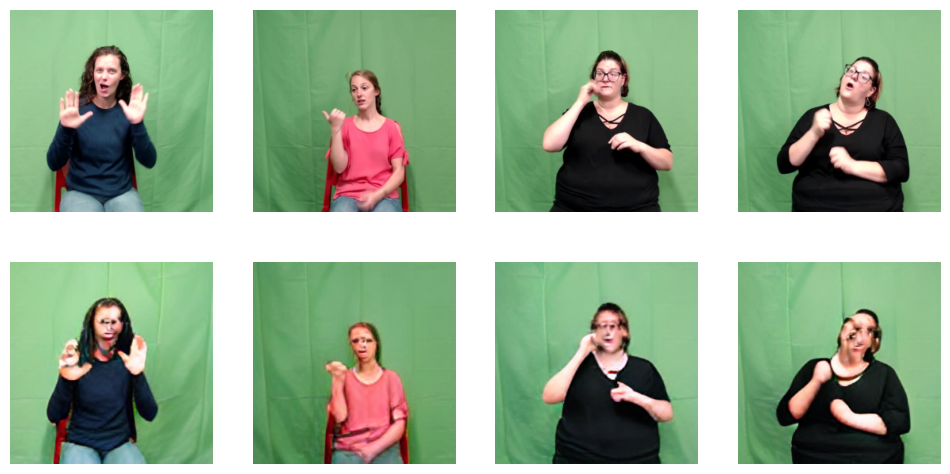

 Codebook saved.


In [15]:
# 9. Evaluation and save codebook
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    imgs = next(iter(val_loader)).to(cfg.device)
    # rec = model(imgs)['dec'] # Original line causing error
    # Try accessing the first element, assuming it's the reconstructed image
    output = model(imgs)
    # Check if the output is a tuple and has at least one element
    if isinstance(output, tuple) and len(output) > 0:
        rec = output[0] # Access the first element of the tuple
    elif isinstance(output, torch.Tensor):
         rec = output # If it's already the tensor
    else:
        print(f"Unexpected output type from model forward: {type(output)}")
        # Depending on the actual output, you might need to adjust this
        # For now, let's assume the first element or the tensor itself is the reconstruction
        # If the error persists, print the 'output' variable to inspect its structure
        raise TypeError("Model forward output is not a tuple or tensor as expected.")


fig, axes = plt.subplots(2,4, figsize=(12,6))
for i in range(4):
    axes[0,i].imshow(((imgs[i].cpu().permute(1,2,0)+1)/2).clamp(0,1))
    axes[0,i].axis('off')
    axes[1,i].imshow(((rec[i].cpu().permute(1,2,0)+1)/2).clamp(0,1))
    axes[1,i].axis('off')
plt.show()

torch.save(model.quantize.embedding.weight, os.path.join(cfg.save_dir, "vqgan_f16_codebook.pt"))
print(" Codebook saved.")

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Using 1000 images for validation:
/content/unzipped_frames/cosmos_training frames/0oGfy530AuI_7-1-rgb_front_kf49_idx70.jpg
/content/unzipped_frames/cosmos_training frames/bb1Z5dw4N-s_2-8-rgb_front_kf23_idx65.jpg
/content/unzipped_frames/cosmos_training frames/a5yNwUSiYpA_5-3-rgb_front_kf01_idx0.jpg
/content/unzipped_frames/cosmos_training frames/DEdVsXBut4I_4-5-rgb_front_kf23_idx31.jpg
/content/unzipped_frames/cosmos_training frames/EjzQn4ReeeI_4-3-rgb_front_kf39_idx88.jpg
/content/unzipped_frames/cosmos_training frames/3EjKvwck6ss_17-1-rgb_front_kf48_idx58.jpg
/content/unzipped_frames/cosmos_training frames/0zvsqf23tmw_14-1-rgb_front_kf34_idx33.jpg
/content/unzipped_frames/cosmos

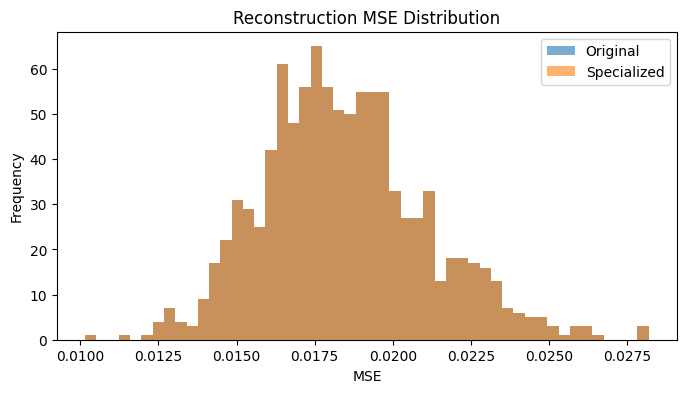

<ipython-input-43-bc69d9cfb080>:114: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mse_list_orig, mse_list_spec], labels=['Original', 'Specialized'])


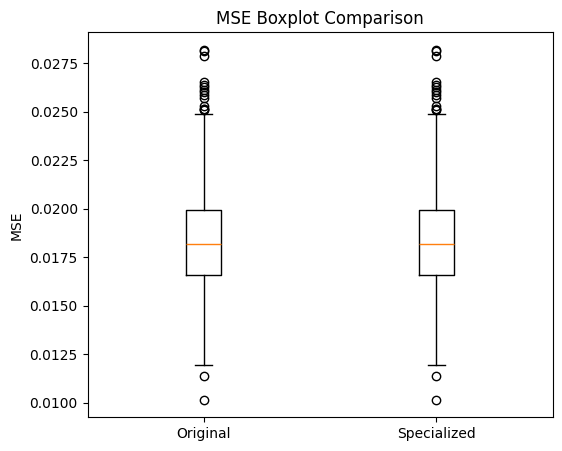

Original Model Reconstruction MSE - mean: 0.0184, median: 0.0182, std: 0.0026


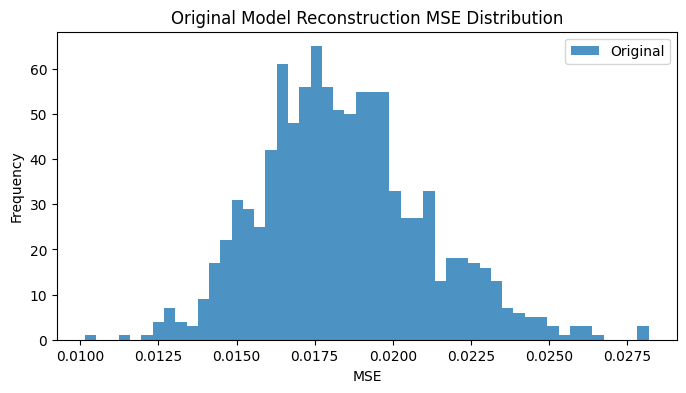

Specialized Model Reconstruction MSE - mean: 0.0184, median: 0.0182, std: 0.0026


In [43]:
### Evaluation and Comparison Cells for Original vs. Specialized VQGAN

# 1. Imports and Setup
import torch
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from taming.models.vqgan import VQModel
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

# 2. Load Models via Configuration
orig_config_path = '/content/checkpoints/vqgan_imagenet_f16_1024.yaml'
orig_ckpt_path   = '/content/checkpoints/vqgan_imagenet_f16_1024.ckpt'
spec_ckpt_path   = '/content/checkpoints/vqgan_f16_epoch1.pth'

# Load model configuration
config = OmegaConf.load(orig_config_path)
orig_kwargs = config.model.params

# Instantiate and load original model
orig_model = VQModel(**orig_kwargs)
state = torch.load(orig_ckpt_path, map_location='cpu')
orig_model.load_state_dict(state['state_dict'])
orig_model.eval()

# Instantiate and load specialized model
spec_model = VQModel(**orig_kwargs)
spec_state = torch.load(spec_ckpt_path, map_location='cpu')
state_dict = spec_state.get('state_dict', spec_state)
spec_model.load_state_dict(state_dict)
spec_model.eval()

# Send to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
orig_model.to(device)
spec_model.to(device)

# 3. Prepare Validation Data
# Sample N images from the training frames folder (with common image extensions)
import glob, random, os
from PIL import Image
from torchvision.datasets.folder import default_loader

frame_folder = '/content/unzipped_frames/cosmos_training frames'
# Look for common image files, recursively
extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tif', '*.tiff')
all_paths = []
for ext in extensions:
    all_paths.extend(glob.glob(os.path.join(frame_folder, '**', ext), recursive=True))

if len(all_paths) == 0:
    raise FileNotFoundError(f"No image files found in {frame_folder} with extensions {extensions}.")

# sample up to 10 random image files
num_val = min(1000, len(all_paths))
sampled_paths = random.sample(all_paths, num_val)
print(f"Using {num_val} images for validation:")
for p in sampled_paths:
    print(p)

# Custom dataset for these sampled files
def make_sample_dataset(paths, transform):
    class SampleDataset(torch.utils.data.Dataset):
        def __init__(self, paths, transform):
            self.paths = paths
            self.transform = transform
            self.loader = default_loader

        def __len__(self):
            return len(self.paths)

        def __getitem__(self, idx):
            img = self.loader(self.paths[idx])
            return self.transform(img), 0  # dummy label

    return SampleDataset(paths, transform)

# Set up transforms and DataLoader
img_size = 256
transform = T.Compose([
    T.Resize(img_size),
    T.CenterCrop(img_size),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])
val_dataset = make_sample_dataset(sampled_paths, transform)
dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# 4. Compute Reconstruction Metrics (MSE). Compute Reconstruction Metrics (MSE) Compute Reconstruction Metrics (MSE)
mse_list_orig, mse_list_spec = [], []
with torch.no_grad():
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        out_orig, *_ = orig_model(imgs)  # unpack reconstruction from tuple
        out_spec, *_ = spec_model(imgs)
        mse_o = torch.mean((imgs - out_orig)**2, dim=[1,2,3]).cpu().numpy()
        mse_s = torch.mean((imgs - out_spec)**2, dim=[1,2,3]).cpu().numpy()
        mse_list_orig.extend(mse_o.tolist())
        mse_list_spec.extend(mse_s.tolist())

# 5. Plotting in English
plt.figure(figsize=(8,4))
plt.hist(mse_list_orig, bins=50, alpha=0.6, label='Original')
plt.hist(mse_list_spec, bins=50, alpha=0.6, label='Specialized')
plt.legend()
plt.title('Reconstruction MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6,5))
plt.boxplot([mse_list_orig, mse_list_spec], labels=['Original', 'Specialized'])
plt.title('MSE Boxplot Comparison')
plt.ylabel('MSE')
plt.show()

# 6. Original Model MSE Summary and Separate Plot
# Compute summary statistics for Original model
orig_mean = np.mean(mse_list_orig)
orig_median = np.median(mse_list_orig)
orig_std = np.std(mse_list_orig)
print(f"Original Model Reconstruction MSE - mean: {orig_mean:.4f}, median: {orig_median:.4f}, std: {orig_std:.4f}")

# Plot only the Original model MSE distribution
plt.figure(figsize=(8,4))
plt.hist(mse_list_orig, bins=50, alpha=0.8, label='Original')
plt.legend()
plt.title('Original Model Reconstruction MSE Distribution')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.show()

# Optionally, plot summary for Specialized model too
spec_mean = np.mean(mse_list_spec)
spec_median = np.median(mse_list_spec)
spec_std = np.std(mse_list_spec)
print(f"Specialized Model Reconstruction MSE - mean: {spec_mean:.4f}, median: {spec_median:.4f}, std: {spec_std:.4f}")


>Results are very similar since we trained only on one epoch due to ressource constraint